In [12]:
include("smc.jl")
ENV["JULIA_DEBUG"] = Main
push!(LOAD_PATH, "../../../../research/BooleanSatisfiability.jl/src/")
import BooleanSatisfiability as SAT
println("self test")
import Convex
using Plots

self test


In [13]:
# In this problem we want to plan a 2D trajectory x,y over N steps
# TODO we may complicate it later by adding a quadratic approximation to nonlinear dynamics

N = 10
x = Convex.Variable(N)
y = Convex.Variable(N)

Variable
size: (10, 1)
sign: real
vexity: affine
id: 147…351

In [14]:
x_world = [0.,10.]
y_world = [0.,5.]
bounds = [0.,0.,10.,5.]
start   = [0.25,0.25]
goal    = [9.75, 2.]

# obstacles are represented by two corners (x1, y1, x2, y2)
obs_1 = [2.,0.,4.,3.]
obs_2 = [7.,1.,9.,3.5]
obs_3 = [7.,4.,9.,5.]

plot_rect(obs) = (obs[[1,3,3,1,1]], obs[[2,2,4,4,2]])

function plot_env()
    plot(plot_rect(bounds)..., color=:green, xlim=x_world, ylim=y_world, primary=false)
    plot!(plot_rect(obs_1)..., color=:red, primary=false)
    plot!(plot_rect(obs_2)..., color=:red, primary=false)
    plot!(plot_rect(obs_3)..., color=:red, primary=false)
    scatter!(start[1:1], start[2:2], markersize=5, color=:blue)
    scatter!(goal[1:1], goal[2:2], markersize=5, color=:orange, marker=:star)
end

plot_env (generic function with 1 method)

In [15]:
function outside_box_at_step(xi, yi, box::Array{Float64}) :: Array{NodeType}
    x1, y1, x2, y2 = box
    return [(xi <= x1) ∨ (xi >= x2) ∨ (yi <= y1) ∨ (yi >= y2)]
end

function outside_box_in_interval(x, y, box, N1=1, N2=Inf)
    if length(x) != length(y)
        println("Warning: x and y are different lengths")
    end
    if isinf(N2)
        N2 = min(length(x), length(y))
    end
    xys = Any[(x[i], y[i]) for i=N1:N2]
    append!(xys, [(0.5*(x[i]+x[i+1]), 0.5*(y[i] + y[i+1])) for i=N1:N2-1])
    return reduce(vcat, map( xy -> outside_box_at_step(xy[1], xy[2], box), xys ))
end

outside_box_in_interval (generic function with 3 methods)

In [16]:
umax = 5.0
#control_bounds = map( (i) -> Convex.square(x[i]-x[i-1]) + Convex.square(y[i]-y[i-1]) <= umax, 2:N )
control_bounds_x = map( (i) -> Convex.abs(x[i]-x[i-1]) <= umax, 2:N )
control_bounds_y = map( (i) -> Convex.abs(y[i]-y[i-1]) <= umax, 2:N )

constraints = vcat(
    [x >= bounds[1], y >= bounds[2], x <= bounds[3], y <= bounds[4],
     x[1] == start[1], y[1] == start[2], x[end] == goal[1], y[end] == goal[2]],
                   control_bounds_x, control_bounds_y,
                   outside_box_in_interval(x, y, obs_1),
                   #outside_box_in_interval(x, y, obs_2),
                   #outside_box_in_interval(x, y, obs_3),
                  )

obj = Convex.sumsquares(x[2:end]-x[1:end-1]) + Convex.sumsquares(y[2:end]-y[1:end-1])
prob = SmcProblem(obj, constraints)
smc_solve!(prob, 1e-2, SCS.Optimizer, 500)
#abstraction!(prob)

┌ Debug: solve! optval 8.430623566612434
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 7.74999987401011
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 7.7499999999291616
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240


WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 48 empty
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 48 empty
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 em

┌ Debug: solve! optval 9.910615747146949
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 5.249964798690269
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.0970802513726695e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.8376982854703403e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 8.912068425861724e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.0316564242763625e-12
└ @ Main /home/esoroka/Desktop/localfiles

p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 87 empty
WARN: A->p (column pointers) 

┌ Debug: solve! optval 12.777735905141194
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 5.250004689440578
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.168203138008851e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.1714927367127052e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.1624266156881522e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.76187657679599e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.854945897096581e-10
└ @ Main /home/esoroka/

ty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (colum

┌ Debug: iis_status in iis() = OPTIMAL -4.9812948207537705e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.281934382396245e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.249999999918325
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 14.96524571046052
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 6.374990500912192
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.484801608831977e-11
└ @ Main /home/esoroka/Desktop/localfiles/For

t strictly increasing, column 58 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 48 empty
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers

┌ Debug: solve! optval 16.93060583688365
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 8.374976200727756
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.68115171368648e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.4156751081110852e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3383811107217528e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.856513422788252e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.250000000350824
└ @ Main /home/esoroka/Desk

n pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (c

┌ Debug: iis_status in iis() = OPTIMAL 8.119515818768864e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.126927060005151e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.749999999560929
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 11.571397938460063
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.3750118465940158
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -6.6628195984304e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.5073713915316644e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240


umn pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, colu

┌ Debug: iis_status in iis() = OPTIMAL 8.479944068057e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0177785986600614e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.1878768123407427e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 6.246096492308398e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.592207483596269e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.1093154874666253e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.837

lumn pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, col

┌ Debug: solve! optval 14.562520707711007
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 3.3749880123376665
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.7694965740640254e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.2232744409161863e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.998867696771363e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.6480610359812793e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.549781460871852e-10
└ @ Main /home/esorok

 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not 

┌ Debug: iis_status in iis() = OPTIMAL 6.155105952717389e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.694986295678738e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.113672841211469e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.0817359934249116e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.1571156945800556e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.25000000115429455
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240


ARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly in

┌ Debug: solve! optval 18.111368102218794
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.3749953527653713
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 2.699166718570419e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.362427222366608e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.477599615907572e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.031965262821407e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.4811898387775793e-6
└ @ Main /home/esoroka/Des


WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column 

┌ Debug: solve! optval 16.53339690657609
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.3750004463019796
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 2.699166718570419e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.8194123514499796e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.484844947344702e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.474886130609077e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.9314795528203e-10
└ @ Main /home/esoroka/Deskto

(column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, 

┌ Debug: iis_status in iis() = OPTIMAL 8.418530695654826e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.8271224305486665e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.093992191199098e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.325382793369494e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.0010463418914128e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3975228897292744e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 6.184374825077441e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in

lumn 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) 

┌ Debug: solve! optval 17.499919996189913
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.8750033013061718
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -2.5388162764928277e-19
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.4552501950777366e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.2960312897374162e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.462424939005796e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.455582357170539e-10
└ @ Main /home/esor

column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN

┌ Debug: solve! optval 17.072826305254257
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.3749997611104172
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 8.119515818768864e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.6874920716235613e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.799827905110324e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.775802406884036e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.822918444121088e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.25000000049420223
└ @ Main

t strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN

┌ Debug: solve! optval 17.34378789995804
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.87500844579219
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.1997112998617049e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.956693178903297e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3690018389429206e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.9659422394589834e-11
└ @ Main /home/esoroka/Desktop/localfiles

increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 48 empty
WARN: A->p (column pointers) not stric

┌ Debug: solve! optval 16.8438244635866
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 4.375041946622474
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 7.206152261301564e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.827002260933602e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.091367313877268e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.281646850588819e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.2601434351821721e-9
└ @ Main /home/esoroka/Deskt

 pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not stric

┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.221983697920826e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.6853466951832263e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0817901134206141e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0969956707823771e-11
└ @ Main /home/esoroka/Desktop/lo

mpty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not stric

┌ Debug: solve! optval 14.320323238914542
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.874982990766004
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.711553544011756e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.014227051650572e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3269753069289266e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.8514933400588898e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.9999999921127443
└ @ Main /home/esoroka/De

empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not stri

┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.220644828736947e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.0000000001000213
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 17.500000098084122
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 4.375001735470903
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -5.394192179488957e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 6.262563013779712e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.499999999984963
└ @ Main /home/esoroka/Desktop/

, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increa

┌ Debug: solve! optval 18.083358624128078
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 7.49999732188367
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.5886195415936354e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.809703211950761e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.9999998056559575
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 14.124972406878552
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 5.749999696811247
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.

mn pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, colum

┌ Debug: solve! optval 11.070286952294392
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 3.75000263014073
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 1.769615979194354e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.7500000004673053
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240


ng, column 56 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly incr

┌ Debug: solve! optval 16.9999647500377
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 4.875018170469712
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 8.08103200129374e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0907128340793718e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.718940408687601e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.4407094766247192e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.455024617828817e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.626802883527202e-11
└ @ Main

s) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty

┌ Debug: solve! optval 13.92670409261942
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.8750191730081274
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 7.768047151327243e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.0060235816895076e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 6.622482199988566e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 5.783421519425562e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.5687792043805533e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.7217460040660875e-10
└ @ 

ictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->

┌ Debug: solve! optval 13.999758376652405
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.8749906865468895
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -5.685499943585265e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.227520235231632e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.2215019113099398e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.7286544503644375e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.555235302699152e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.341376903542892e-11
└

ARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 52 empty
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly in

┌ Debug: solve! optval 14.39200420816409
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.999980101196559
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.4479505424723871e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0328184069136538e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0189563424606656e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.989483351015402e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.091283766123155e-6
└ @ Main /home/esoroka/Des

rictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) no

┌ Debug: iis_status in iis() = OPTIMAL 8.327167834111764e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.199362437035951e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.772030966577208e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.205079880857204e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.412093829415703e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.7493900453091916e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.2996255561202785e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in

y
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than 

┌ Debug: solve! optval 15.26006217508589
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 3.2499778361128424
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -1.9133763171589901e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.972260058839697e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.18172561450304e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.2766868610149744e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0000000000263611
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 13.641777198433246
└ @ Main /home/esoroka/Deskt

p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: m less than n, problem likely degenerate
WARN:

┌ Debug: solve! optval 15.750057669441375
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.3749970076579645
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -5.394192179488957e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.219590808305302e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.810182826399843e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.554018969959289e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.843316437748333e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.578451922282376e-9
└ 

┌ Debug: solve! optval 14.424041550583558
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.37499735004463275
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 2.1845933561443906e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.97311319035398e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.1053092175479785e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.49582122468772e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.2285642207581581e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.86761408567035e-7
└ @ Ma

pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not stric

┌ Debug: solve! optval 16.256638416166435
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.37500329190284765
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -2.042868666751559e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.923529705734132e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.2092667929196923e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.243800993290884e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.2536631052080017e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.8415411136822388e-11

A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointer

┌ Debug: iis_status in iis() = OPTIMAL -6.658325146679387e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.4489163900854322e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.481167748477755e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.6913902774916458e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.311638380457526e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.971717691315348e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0340288785993621e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_statu

 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not str

┌ Debug: solve! optval 20.13516681943827
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.124999199994498
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 6.76390975633317e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.200106016440158e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.73996647312122e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.924593074940229e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.3334475158934393e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.2440626195250038e-10
└ @ Ma

: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column point

┌ Debug: solve! optval 18.24274259091915
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.125001241425449
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.145699249829997e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.248882262895731e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 8.501547680029583e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.593258134621685e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.175025818470199e-10
└ @ Main /home/esoroka/Deskt

A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointer

┌ Debug: iis_status in iis() = OPTIMAL -2.9334684750243146e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.798171391200741e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.309079478680963e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.57701365825877e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.2975658305738383e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.431835913600667e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.8264795496808775e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis

increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 7

┌ Debug: solve! optval 19.693184384487513
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.8750355580703613
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -2.5157021583617286e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.6542847222553876e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.473596914637488e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.162174894001405e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.3616515726455731e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.1002389667994623e-9
└ @ 

>p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 84 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 87 empty
WARN: A->p (column pointers) not strictly increasing, column 85 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: A->p (column pointers) not strictly increasing, column 87 empty
WARN: A->p (column pointers) not strictly increasing, column 86 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasin

┌ Debug: solve! optval 21.753131013004115
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 6.375013088891173
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -4.2321052731166464e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.511161680764878e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.0000000000148273
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: solve! optval 19.752155349138917
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 4.374998074216694
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -7.612052503775831e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc

n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 53 empty
WARN: A->p (column pointers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (co

┌ Debug: solve! optval 17.53338231097578
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.37498848029818044
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -2.696784658277216e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.866624213404554e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.2547755991991127e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.4019299176938416e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.549150017362959e-6
└ @ Main /home/esorok

 A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
W

┌ Debug: solve! optval 17.555808083778516
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.37500026421139243
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 6.76390975633317e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.979893301693876e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.625175509452107e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0245958630216083e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 7.279670584520125e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.184512801139174e-11
└ @ 

RN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 74 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly inc

┌ Debug: iis_status in iis() = OPTIMAL -4.1720110307377245e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.4204801397411441e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.0808570405460535e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.036828257586007e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.874277903440305e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3452636568952449e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.9073331593169455e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status i

olumn pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, co

┌ Debug: solve! optval 16.036057176733543
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 2.3749734783227106
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 8.418530695655625e-13
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.0067549974478364e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.503134646235989e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.9999999966522017
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240


ers) not strictly increasing, column 54 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 55 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, column 56 empty
WARN: A->p (column pointers) not strictly increasing, column 57 empty
WARN: A->p (column p

┌ Debug: solve! optval 15.080459416410962
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.37500003629746187
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -4.208708136749121e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.205111047469079e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.1023711478328494e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.634422991257037e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.310305554578664e-10
└ @ Main /home/esoroka/

s than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 69 empty
WARN: A->p (column pointers) not strictly increasing, column 70 empty
WARN: A->p (column pointers) not strictly increasing, column 71 empty
WARN: A

┌ Debug: iis_status in iis() = OPTIMAL 1.712888121083017e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.877767799142083e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.2222223840408318e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0752311578373452e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.0140019430922786e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.1123892382391558e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.175043884152462e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis()

easing, column 71 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 75 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: A->p (column pointers) not strictly increasing, column 76 empty
WARN: A->p (column pointers) not strictly increasing, column 77 empty
WARN: A->p (column pointers) not strictly increasing, column 78 empty
WARN: A->p (column pointers) not strictly increasing, column 79 empty
WARN: A->p (column pointers) not strictly increasing, column 73 em

┌ Debug: solve! optval 17.531645420415728
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.3749960768576734
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -2.696784658277216e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.0706954377053226e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.6276328892569063e-11
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.710163682183159e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.563883184370039e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.353605984672595e-11
└ @

┌ Debug: iis_status in iis() = OPTIMAL 3.0853439068346465e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.9539402816028894e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -9.423771754553716e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 4.220262668846354e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.5136080946394498e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.831177093905068e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.5342191182295176e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in i

rictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) not strictly increasing, column 62 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 61 empty
WARN: A->p (column pointers) no

┌ Debug: solve! optval 13.647410181902197
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 0.3749996441323754
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL -4.208708136749121e-12
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 9.962829446685283e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.082376741150713e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.303039487668016e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0652822140523005e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.339291328287594e-10
└ @ M

┌ Debug: iis_status in iis() = OPTIMAL 4.98190212272887e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -6.982821447697563e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.0329509888522415e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.865719122013993e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.3486327576151822e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -2.5619733861762155e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -8.5490844319911e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() 

┌ Debug: iis_status in iis() = OPTIMAL 1.362687351188399e-5
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.771948496765596e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.5290384501937244e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.291290889019944e-5
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -4.0263172883786844e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.1798968587127548e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.103794902919574e-5
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis(

olumn pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: A->p (column pointers) not strictly increasing, column 81 empty
WARN: A->p (column pointers) not strictly increasing, column 82 empty
WARN: A->p (column pointers) not strictly increasing, column 83 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 48 empty
WARN: A->p (column pointers) not strictly increasing, column 49 empty
WARN: A->p (column pointers) not strictly increasing, column 50 empty
WARN: A->p (column pointers) not strictly increasing, column 51 empty
WARN: A->p (column pointers) not strictly increasing, co

┌ Debug: solve! optval 18.44196989462439
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:288
┌ Debug: iis_optval 1.999981053812905
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:223
┌ Debug: iis_status in iis() = OPTIMAL 0.0
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.497872158878353e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.3132579147210463e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.6851331888762633e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -5.974237208075952e-10
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.868157973170195e-10
└ @ Main /home/esoroka

┌ Debug: iis_status in iis() = OPTIMAL -3.0672248455364466e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.8733501750080772e-5
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 2.306602786535856e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.357015892244832e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 1.893952723712352e-9
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.0137010768700799e-6
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -3.5832099008151833e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis(

column pointers) not strictly increasing, column 72 empty
WARN: A->p (column pointers) not strictly increasing, column 73 empty
WARN: m less than n, problem likely degenerate
WARN: A->p (column pointers) not strictly increasing, column 58 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
WARN: A->p (column pointers) not strictly increasing, column 63 empty
WARN: A->p (column pointers) not strictly increasing, column 64 empty
WARN: A->p (column pointers) not strictly increasing, column 65 empty
WARN: A->p (column pointers) not strictly increasing, column 66 empty
WARN: A->p (column pointers) not strictly increasing, column 67 empty


┌ Debug: iis_status in iis() = OPTIMAL -9.224158299287144e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL 3.1506112884578625e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -1.1588728201261316e-8
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Debug: iis_status in iis() = OPTIMAL -7.812765166467128e-7
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:240
┌ Warning: Expanded s to 2
└ @ Main /home/esoroka/Desktop/localfiles/Ford/smc_mp (julia)/code/smc.jl:195


LoadError: BoundsError: attempt to access 2×1 Matrix{Convex.Variable} at index [1:46]

In [17]:
println(prob.status)
println("all true:")
println(round.(x.value .- bounds[1], digits=3))
println(round.(-x.value .+ bounds[3], digits=3))
println(round.(y.value .- bounds[2], digits=3))
println(round.(-y.value .+ bounds[4], digits=3))
println("$(x.value[1]) = $(start[1])\n$(y.value[1]) = $(start[2])
$(x.value[end]) = $(goal[1])\n$(y.value[end]) = $(goal[2])")
println(round.(x.value, digits=2))
println(round.(y.value, digits=2))

UNSAT
all true:
[0.25; 1.801; 6.582; 1.818; 0.979; 1.232; 0.887; 1.69; 6.598; 9.75]
[9.75; 8.199; 3.418; 8.182; 9.021; 8.768; 9.113; 8.31; 3.402; 0.25]
[0.25; 0.871; -0.0; 1.318; 2.093; 2.463; 2.797; 3.431; 4.856; 2.0]
[4.75; 4.129; 5.0; 3.682; 2.907; 2.537; 2.203; 1.569; 0.144; 3.0]
0.2499880783458409 = 0.25
0.250007475483966 = 0.25
9.750004888500081 = 9.75
1.9999918413202942 = 2.0
[0.25; 1.8; 6.58; 1.82; 0.98; 1.23; 0.89; 1.69; 6.6; 9.75]
[0.25; 0.87; -0.0; 1.32; 2.09; 2.46; 2.8; 3.43; 4.86; 2.0]


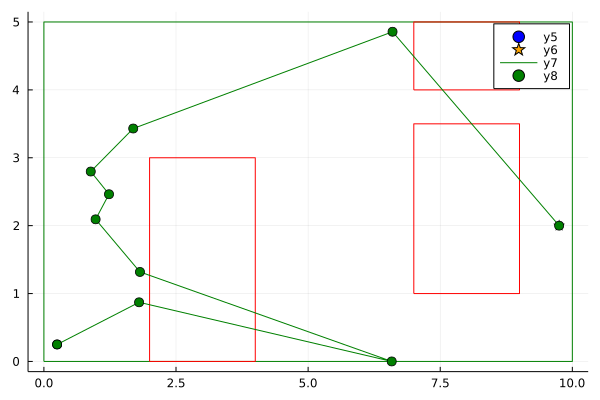

In [18]:
plot_env()
plot!(x.value, y.value, color=:green)
scatter!(x.value, y.value, color=:green, markersize=5)

In [19]:
println(x.value)
println(goal[1])

[0.2499880783458409; 1.8013103287934595; 6.5820211089812375; 1.8176236964487364; 0.9785019861656925; 1.2320043153252127; 0.8867981489350463; 1.690325930690262; 6.597606652950941; 9.750004888500081]
9.75


In [20]:
println(y.value)
println(goal[2])

[0.250007475483966; 0.8710694482785467; -1.4996310194803803e-7; 1.3180529540425217; 2.0932807406892735; 2.4630661052789846; 2.7974309395773855; 3.4309754833398185; 4.856249236382912; 1.9999918413202942]
2.0


In [21]:
println(round.((x.value[2:end]-x.value[1:end-1]), digits=2))
println(round.((y.value[2:end]-y.value[1:end-1]), digits=2))

[1.55, 4.78, -4.76, -0.84, 0.25, -0.35, 0.8, 4.91, 3.15]
[0.62, -0.87, 1.32, 0.78, 0.37, 0.33, 0.63, 1.43, -2.86]


In [22]:
obj = Convex.sumsquares(x[2:end]-x[1:end-1])

qol_elem (convex; positive)
├─ norm2 (convex; positive)
│  └─ + (affine; real)
│     ├─ index (affine; real)
│     │  └─ …
│     └─ - (affine; real)
│        └─ …
└─ [1.0]